<a href="https://colab.research.google.com/github/IHMilon/vision-model-comparison/blob/main/4.%20ResNet_CIFAR100/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ResNet on CIFAR-100**

In this project, I implement and train a **Residual Neural Network (ResNet)** on the **CIFAR-100 dataset**.  
The goal is to explore the effectiveness of deep residual learning in classifying 100 object categories.

---

## Overview
- **Dataset**: CIFAR-100 (60,000 images, 32×32, 100 classes)  
- **Architecture**: ResNet inspired custom model.  
- **Objective**: Achieve high classification accuracy with proper training pipeline

## **Install Required Package**

In [1]:
!pip install torchprofile 1>/dev/null

## **Import Libraries**

In [2]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchprofile import profile_macs
from sklearn.metrics import confusion_matrix
from collections import namedtuple
from tqdm.auto import tqdm
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR

## **Reproducibility**

In [3]:
seed = 40
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## **Device Setup**

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is : {device}")

Device is : cuda


## **Images Transformations**
I apply Data Transformation to increase the size of training data, since **CIFAR-100** contains only 600 images per class. It will also improve the model performance and generalization.

In [5]:
# Train transformation
train_transforms = transforms.Compose([
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.RandAugment(num_ops=2, magnitude=9),
      transforms.ToTensor()
      ])

# Test transformation
test_transforms = transforms.Compose([
      transforms.ToTensor()
      ])

## **Load the Dataset**
I use the pytorch CIFAR100 dataset. Which contains 60k (32, 32) color images. Where,
- **Training data :** 50k images are used for training.
- **Test data :** 10k images are used for testing.

There are total 100 classes and each one contains 600 images. Batch size is kept little bit of higher to make the learning smooth.

In [ ]:
# Prepare Training set
train_set = datasets.CIFAR100(root = "data/cifar100", train = True, download= True, transform = train_transforms)
train_loader = DataLoader(train_set, batch_size = 128, shuffle = True, pin_memory = True)

# Prepare Test set
test_set = datasets.CIFAR100(root = "data/cifar100", train = False, download = True, transform = test_transforms)
test_loader = DataLoader(test_set, batch_size = 128, shuffle = False, pin_memory = True)

## **Inspect the proper Batch loading**

In [7]:
# Get single batch
train_batch = next(iter(train_loader))
#Extract images and labels from the batch
images, targets = train_batch
print(f"Images shape : {images.shape}")
print(f"Targets shape : {targets.shape}")

Images shape : torch.Size([128, 3, 32, 32])
Targets shape : torch.Size([128])


### **Visualize the Batch**
We can visualize few data from a batch to ensure all transformation works properly.

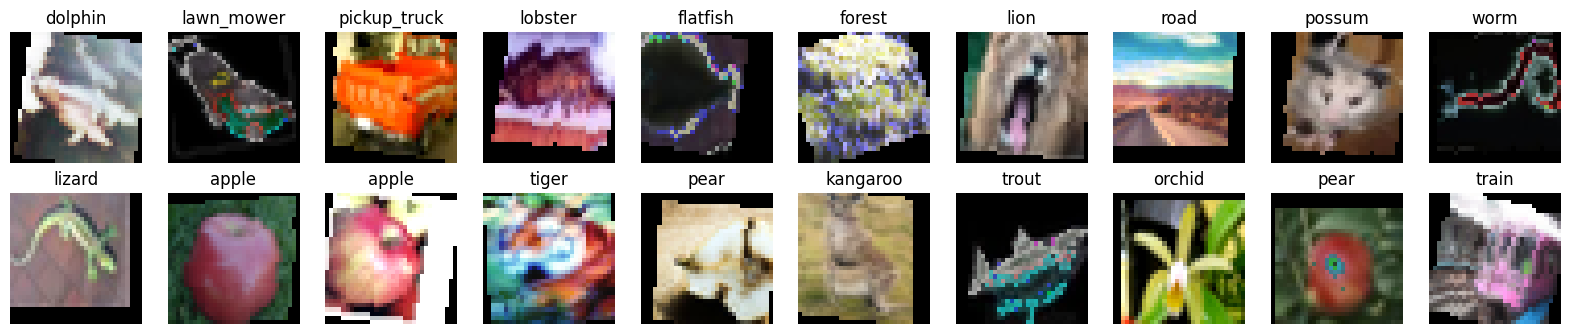

In [8]:
plt.figure(figsize = (20,8))
for i in range (20):
    image = images[i]
    label = targets[i]

    # Get label name from label index
    class_name = train_set.classes[label]

    # Convert CHW to HWC for imshow
    image = image.permute(1,2,0).numpy()

    # Plot the image
    plt.subplot(4, 10, i+1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")
plt.show()

## **Define the Model**

### **ResNet BasicBlock**

This block consists of two sequential `conv-bn-relu` layers with a **3×3** kernel.  
It also includes a **skip (residual) connection** that enables smoother gradient flow, helping to prevent the **vanishing gradient problem** commonly observed in deeper neural networks.

In [9]:
# Build the BasicBlock
class BasicBlock(nn.Module):
    expansion= 1
    def __init__(self, in_channel, channel, stride = 1):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = channel
        self.stride = stride

        self.conv1 = nn.Conv2d(self.in_channel, self.out_channel, kernel_size = 3, padding = 1, stride = self.stride, bias = False)
        self.bn1 = nn.BatchNorm2d(channel)
        self.relu = nn.ReLU(inplace = True)

        self.conv2 = nn.Conv2d(self.out_channel, self.out_channel, kernel_size = 3, padding = 1, stride = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(channel)

        # Skip Connection
        if self.stride != 1 or self.in_channel != self.out_channel:
            self.skip = nn.Sequential(
                 nn.Conv2d(self.in_channel, self.out_channel, kernel_size = 1, stride = stride, bias = False),
                 nn.BatchNorm2d(channel))
        else:
            self.skip = nn.Identity()

    def forward(self, x):

        skip = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        # Skip Connection
        if self.stride != 1 or self.in_channel != self.out_channel:
            skip = self.skip(skip)
        else:
            skip = self.skip(skip)

        x += skip
        x = self.relu(x)
        return x

### **ResNet Full Model**
It starts with an initial `Cconv-bn-relu` layer, followed by a series of **BasicBlocks** for feature extraction. The resulting feature maps are processed by a `AdaptiveAvgPool` layer to capture the most informative representations, and finally passed to a `Linear` layer that outputs predictions across **100 classes**.

In [10]:
class Resnet(nn.Module):
    def __init__(self, block, num_block, channels, output):
        super().__init__()

        self.in_channel = 16

        # Stem layer
        self.conv = nn.Conv2d(3, self.in_channel, kernel_size = 3, stride = 1, padding = 1, bias = False )
        self.bn = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)

        # BasicBlock layers
        self.layer1 = self.make_layer(block, num_block[0], channels[0])
        self.layer2 = self.make_layer(block, num_block[1], channels[1], stride = 2)
        self.layer3 = self.make_layer(block, num_block[2], channels[2], stride = 2)
        self.layer4 = self.make_layer(block, num_block[3], channels[3], stride = 2)

        # Avg pool and FC layer
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channel, output)

    # Helps to make a layer with multiple basicblock
    def make_layer(self, block, num_block, channel, stride = 1):
        layer = []

        layer.append(block(self.in_channel, channel, stride = stride))
        self.in_channel = block.expansion*channel

        for _ in range (1, num_block):
            layer.append(block(self.in_channel, channel, stride = 1))
            self.in_channel = block.expansion*channel
        # Sequentially passes the output
        return nn.Sequential(*layer)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [11]:
model = Resnet(BasicBlock, num_block = [3, 4, 6, 3], channels = [16, 32, 64, 128], output = 100)
model = model.to(device)

## **Model Size**
The model size can be estimated by the number of trainable parameters:

In [12]:
num_param=0
for param in model.parameters():
    if param.requires_grad:
        num_param += param.numel()
print(f" Total Parameters: {(num_param/1000000):.2f} Million")

 Total Parameters: 1.35 Million


## **Computational Cost**
The computation cost can be estimated by the number of multiply–accumulate operations (MACs):

In [13]:
x = torch.zeros(1, 3, 32, 32).to(device)
macs = profile_macs(model,x)
print(f"#MACs: {(macs/1000000):.2f} Million")

#MACs: 73.06 Million


## **Training Setup**
We use `CrossEntropyLoss` as the loss function, `AdamW` optimizer with weight decay for regularization, and the `OneCycleLR` scheduler for dynamic learning rate adjustment. Also Training is performed with `mixed precision` to accelerate computations and reduce GPU memory usage, following best practices in modern deep learning workflows.

In [18]:
Epochs = 50

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 5e-54)

# Initialize the LR scheduler
scheduler = OneCycleLR(optimizer,
            max_lr = 0.01,
            steps_per_epoch = len(train_loader),
            epochs = Epochs
            )
# Initialize the loss Scaler
scaler = GradScaler('cuda')

## **Training Loop**

This section trains the ResNet model over multiple epochs, where each batch of images passes through forward propagation, loss computation, backpropagation, and parameter updates using the optimizer.

In [19]:
# Store Accuracy & loss
train_losses, train_accs = [], []
test_losses, test_accs =[], []

for epoch in range(1, Epochs+1):

    # Training loop
    model.train()

    # Training matrices
    train_loss = 0
    num_samples = 0
    num_correct = 0

    for images, labels in train_loader:
        # Move data to the GPU
        images, labels = images.to(device), labels.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass with Mixed Precision
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # scale the loss and calculate the gradiants
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update the learning rate after each batch
        scheduler.step()

        # convert logits to class indices
        predictions = outputs.argmax(dim=1)

        # update the training matrices
        train_loss += loss.item()
        num_samples += labels.size(0)
        num_correct += (predictions == labels).sum().item()

    # training accuracy and losses
    train_acc = (num_correct/num_samples)*100
    train_losses.append(train_loss/len(train_loader))
    train_accs.append(train_acc)


    # validation loop
    model.eval()

    # test matrices
    test_loss = 0
    test_samples = 0
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion (outputs, labels)

            # Convert logits to class indecies
            predictions = outputs.argmax(dim=1)

            # update test matrices
            test_loss += loss.item()
            test_samples += labels.size(0)
            test_correct += (predictions == labels).sum().item()

        # Testing Accuracies and losses
        test_acc = (test_correct / test_samples)*100
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(test_acc)

    # print accs every after 5 epochs
    if epoch % 5 == 0:
        # Final model performance matrices
        print(f"{epoch}) Train Accuracy {train_accs[-1]:.2f}%, Test Accuracy {test_accs[-1]:.2f}%")
        print("-"*50)

5) Train Accuracy 43.49%, Test Accuracy 42.78%
--------------------------------------------------
10) Train Accuracy 46.34%, Test Accuracy 45.13%
--------------------------------------------------
15) Train Accuracy 51.33%, Test Accuracy 49.75%
--------------------------------------------------
20) Train Accuracy 56.54%, Test Accuracy 57.53%
--------------------------------------------------
25) Train Accuracy 61.08%, Test Accuracy 59.09%
--------------------------------------------------
30) Train Accuracy 66.00%, Test Accuracy 64.32%
--------------------------------------------------
35) Train Accuracy 71.14%, Test Accuracy 66.02%
--------------------------------------------------
40) Train Accuracy 75.69%, Test Accuracy 67.75%
--------------------------------------------------
45) Train Accuracy 78.57%, Test Accuracy 68.72%
--------------------------------------------------
50) Train Accuracy 79.76%, Test Accuracy 68.91%
--------------------------------------------------


## **Loss & Accuracy Plots**

These helps to evaluate the model's performance by visualizing its learning behavior, which allows us to assess issues like overfitting, underfitting, and model capacity.

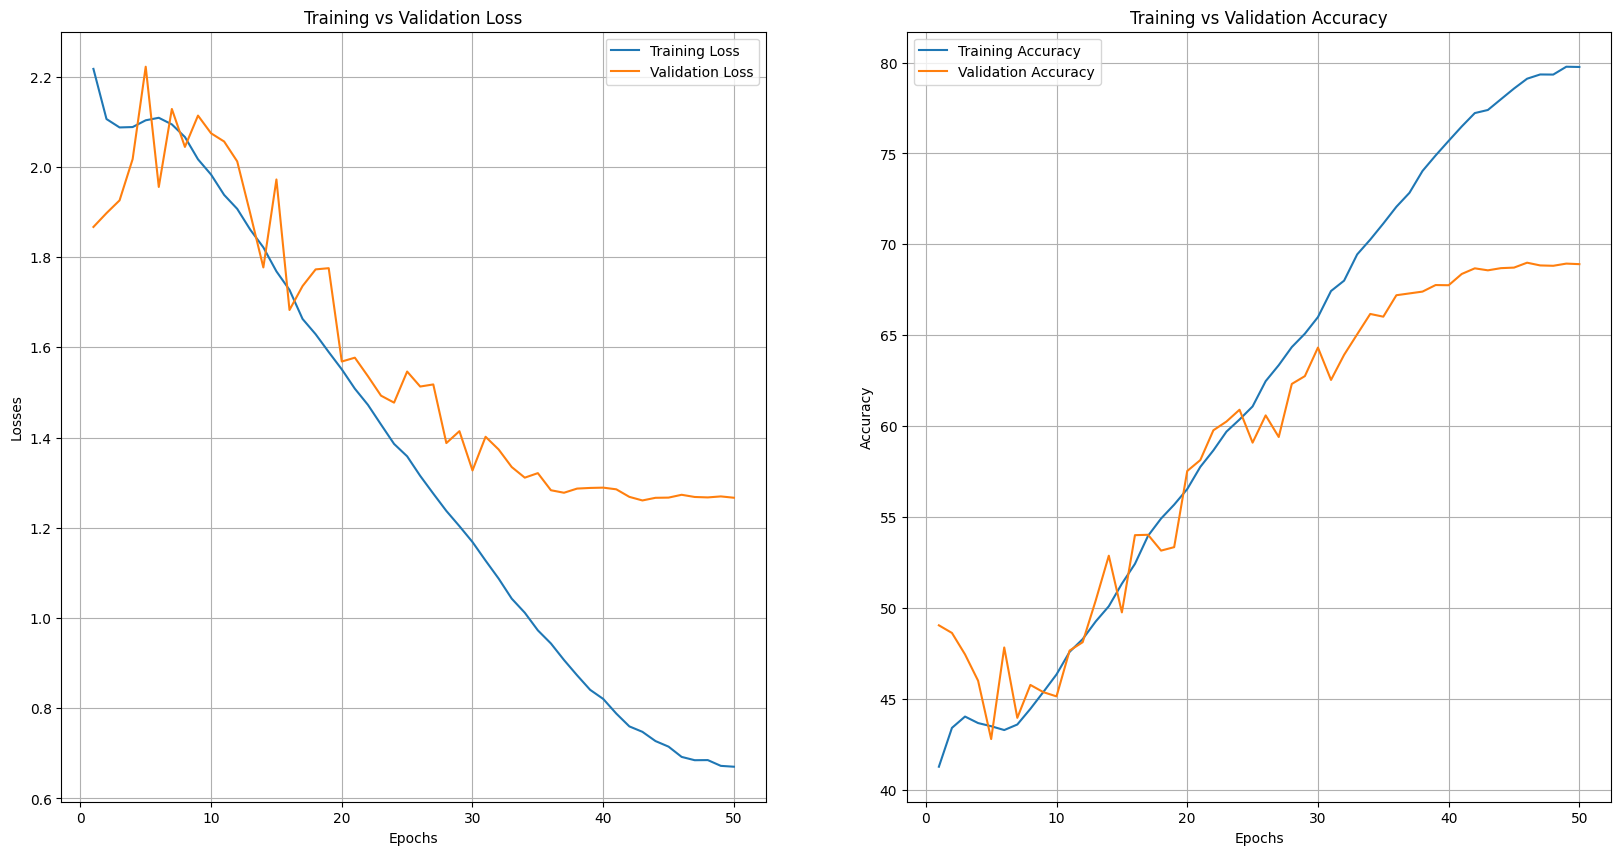

In [20]:
epoch_range = range(1, Epochs+1)
plt.figure(figsize=(20,10))

# Plot the Train and Val Loss
plt.subplot(1,2,1)
plt.plot(epoch_range, train_losses, label = "Training Loss")
plt.plot(epoch_range, test_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Plot the Train and Val Accuracy
plt.subplot(1,2,2)
plt.plot(epoch_range, train_accs, label = "Training Accuracy")
plt.plot(epoch_range, test_accs, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()

## **Predictions Visualization**
We can visualize the model's predictions to see how it performs on test data.

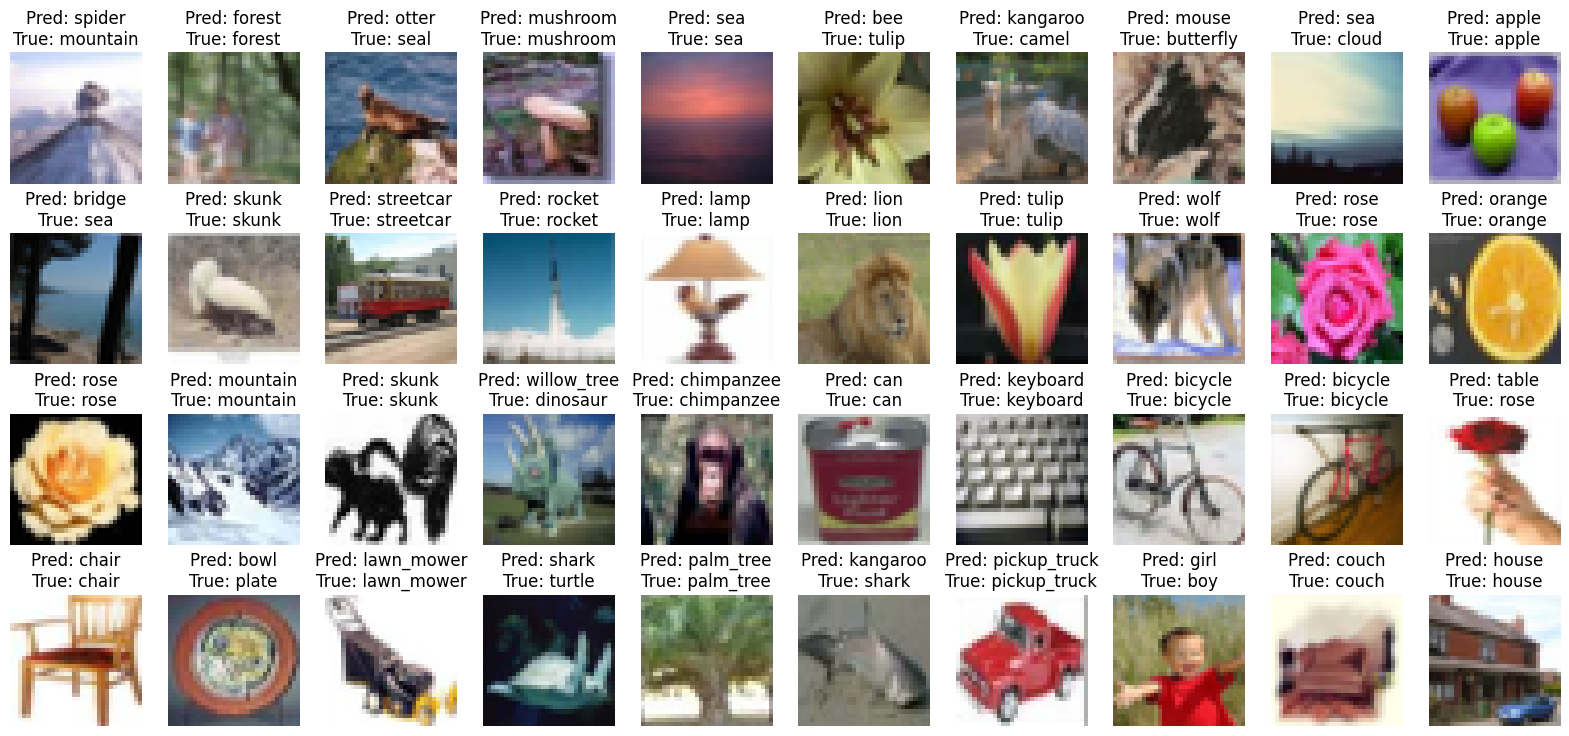

In [21]:
plt.figure(figsize=(20,9))
# Plots 40 images
for i in range (40):
    image, label = test_set[i]
    # Move image to the same device as the model
    image = image.to(device)
    output = model(image.unsqueeze(dim=0))
    # Get label index from raw logits
    pred = output.argmax(dim=1)
    true_name = test_set.classes[label]
    pred_name = test_set.classes[pred]

    # Convert to HWC and move to cpu
    image = image.permute(1,2,0).cpu()

    plt.subplot(4,10, i+1)
    plt.imshow(image)
    plt.title(f"Pred: {pred_name}\nTrue: {true_name}")
    plt.axis("off")
plt.show()

## **Confusion Matrix**
It visualizes the model's performance on the testset. And helps to identify which classes the model confuses the most.

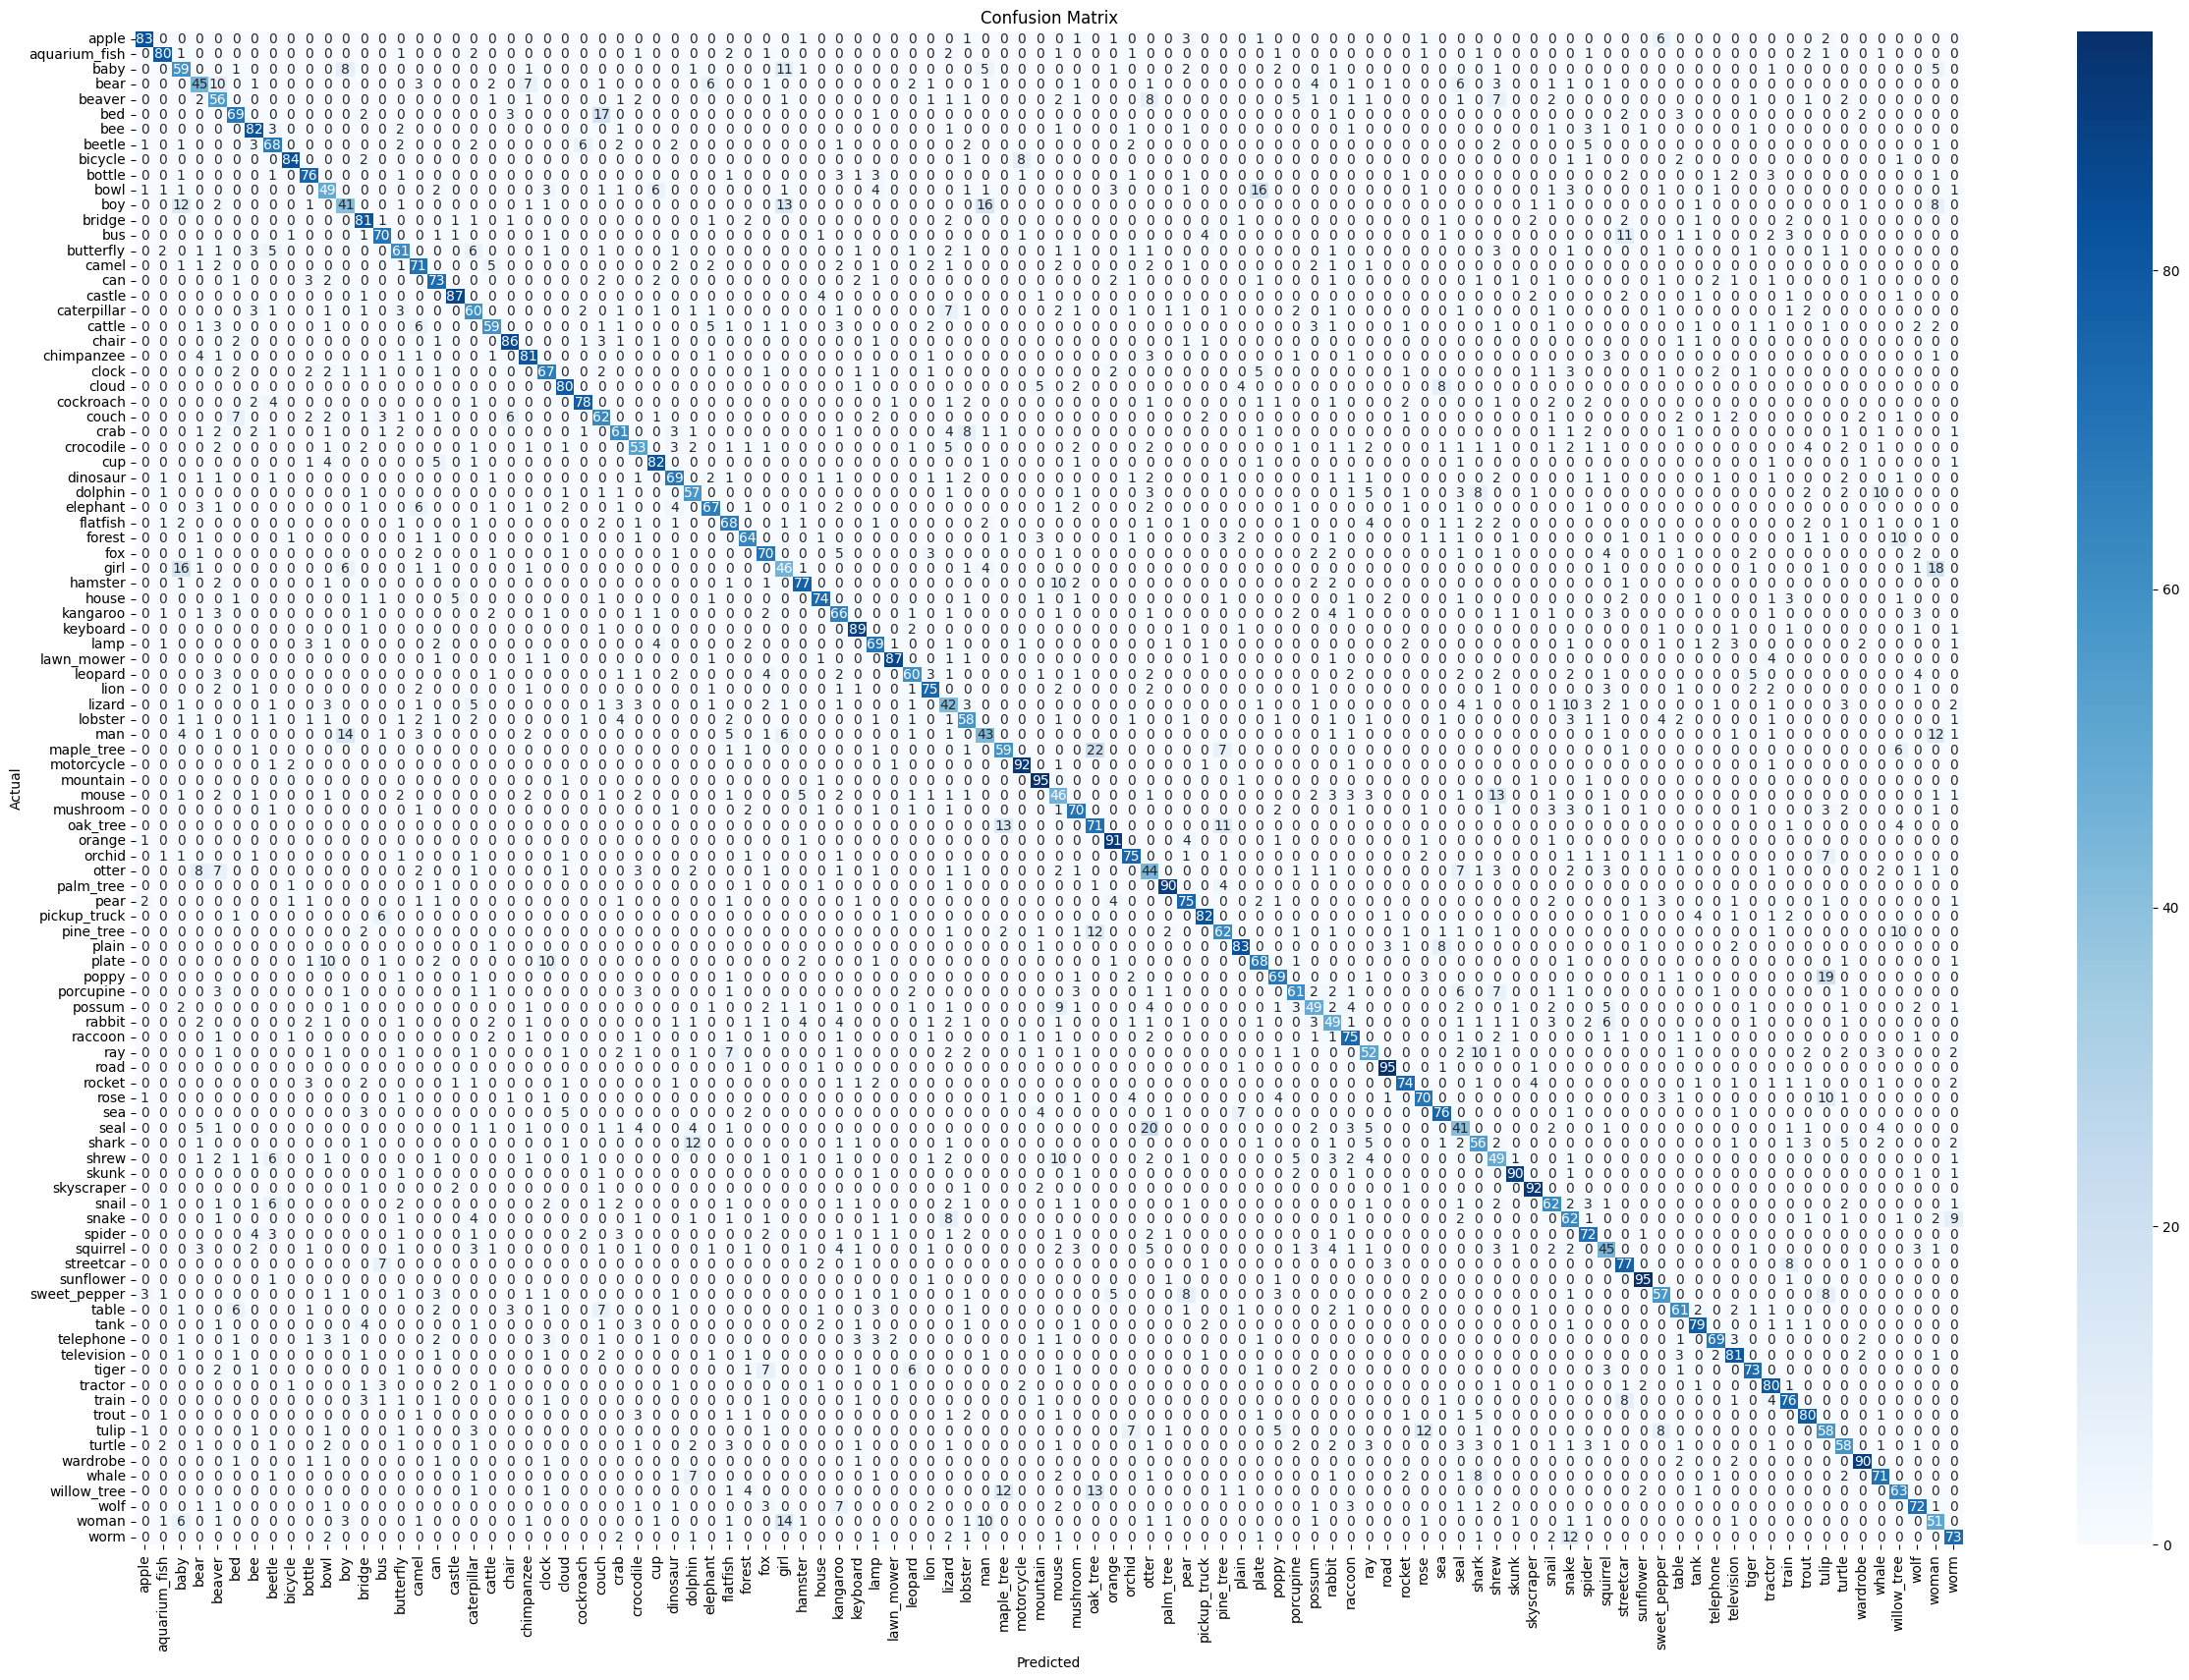

In [22]:
# Collect predictions and true labels
true_labels = []
predictions = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(pred.cpu().numpy())

# Compute confusion matrix
matrix = confusion_matrix(true_labels, predictions)

# Get class name from label index
class_name = test_set.classes

# Plot heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_name, yticklabels=class_name, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **Latency and Throughput**
We can check the model's inference time (Latency) and samples per second (Throughput) to get performance idea:

In [24]:
# Creating fake batch of images
dummy_samples = torch.ones(256, 3, 32, 32).to(device)

model.eval()
# wait for previous ops to finish
torch.cuda.synchronize()
start_time = time.time()

with torch.inference_mode():
    _ = model(dummy_samples)

# wait for previous ops to finish
torch.cuda.synchronize()
end_time = time.time()

# Total time per batch
time = end_time - start_time

# Throughput
throughput = 256 / time

print(f"Time Per Batch: {time*1000:.2f} ms")
print(f"Throughput: {int(throughput)} img/sec")

Time Per Batch: 26.60 ms
Throughput: 9622 img/sec
